# Catalyst Event Analysis
## Probability of Event Outcome Based on Biotech Hedge Fund Form 13s

*Insight into how biotech hedge fund form 13s can allow for probabilistically superior outcomes when predicting results of catalytic events*

### Abstract

> The Form 13s of 8 leading biotech hedge funds were examined and the tickers of the companies present in the filings were recorded. A historical biotech catalyst dataset containing tickers, event description, and event date was found online and scraped to create a dataset of events. The baseline percent occurrence of positive, negative, and none event outcomes was created for each event in the total dataset by measuring the total return 2 days after the event occurred. A total return greater than 0.10 was deemed a positive outcome, a total return less than -0.10 was considered a negative event. Total return matching neither of these criteria was labeled 'na' for none; these were events where the outcome of the catalyst did not have a major impact on price action. The specific events in the dataset that yielded either a positive or negative outcome, called 'pos' or 'neg' respectively, were analyzed as part of a subset of events that were sufficiently volatile (vol) in terms of effect on price action. Alpha generation was calculated over 100 days pre/post the event date or Day 0 for each event in the period of analysis 180 days after the Q1 2019 Form 13 filing date of 2019-5-15. This was to establish a baseline of event outcome occurrence and alpha generation with which to compare the biotech hedge fund tickers. Figures illustrating the significant findings of the analysis are displayed briegly below but explored much more deeply in the Discussion section. The important results were that a list composed of tickers that occurred once or more in a list drawn from the filings of the 8 hedge funds had a greater than baseline occurrence of positive events and a less than baseline occurrence of negative events. These findings become even more apparent when the subset of volatile events is analyzed as shown below. These findings could be helpful in attempting to predict the outcomes of specific catalyst events associated with tickers present in the filings of biotech hedge funds.  

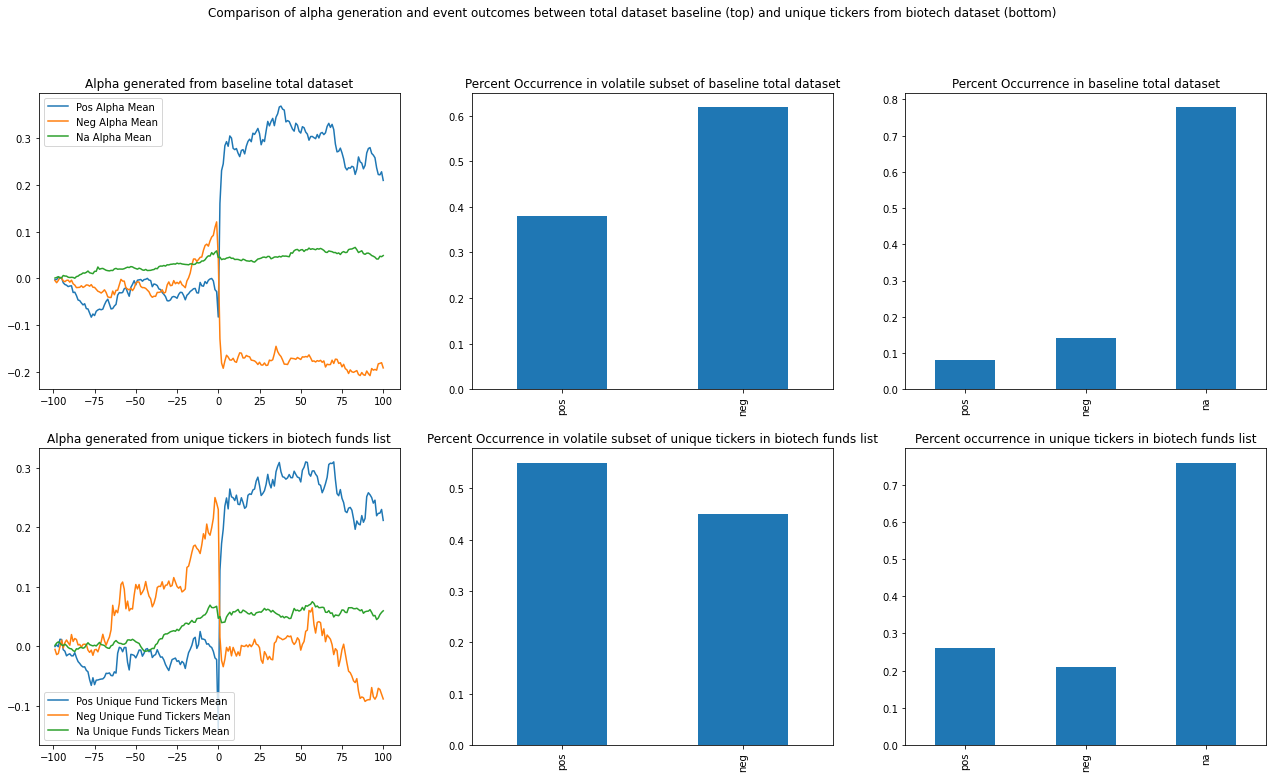

In [165]:
fig, axes = plt.subplots(nrows=2,ncols=3,figsize=(22,12))
fig.suptitle('Comparison of alpha generation and event outcomes between total dataset baseline (top) and unique tickers from biotech dataset (bottom)')
alpha_total.plot(ax=axes[0,0],kind='line',title='Alpha generated from baseline total dataset')
unique_df.plot(kind='line',ax=axes[1,0],title='Alpha generated from unique tickers in biotech funds list')
funds_events['unique_%'].plot(kind='bar',ax=axes[1,2],title='Percent occurrence in unique tickers in biotech funds list')
vol_funds_events['unique_%'].plot(kind='bar',ax=axes[1,1],title='Percent Occurrence in volatile subset of unique tickers in biotech funds list')
events['Percent'].plot(kind='bar',ax=axes[0,2],title='Percent Occurrence in baseline total dataset')
vol_events['Percent'].plot(kind='bar',ax=axes[0,1],title='Percent Occurrence in volatile subset of baseline total dataset')
fig.savefig('output.png')

### Introduction

> The goal of this project is to identify trends in the tickers contained in the Form 13 filings of prominent biotech hedge funds. The hypothesis is that hedge fund positions can have a predictive role in the outcome of catalyst events. Biotech 'Catalysts' or 'Binary' Events are considered to be the major checkpoints in the lifecycle of drug development and thus the overall biotech company. These can include events such as various phases of clinical trial results or the ultimate catalyst, FDA approval or rejection. During which the company either recieves Approval or a Complete Response Letter (CRL) which is basically a rejection of the drug at that time. It is important to note that while a CRL does represent a failure of the company to have the drug approved it does not mean that it will not eventually be approved. There is significant price action associated with all these events due to the major role they play in the ultimate success of the drug and underlying company. Predicting these events correctly can be extremely lucrative but often difficult with more clinical failures occurring than successes. 
   
> Form 13s are quarterly filings required of Hedge Funds over a certain assets under management (AUM); these are filed with the SEC for each financial quarter 45 days after the end of the period. In this report 8 prominent biotech hedge funds were analyzed. The criteria for inclusion in this list was a primary focus on the healthcare sector in the composition of their book (greater than 90%). The filings analyzed were taken from the period of Q1 2019 (Q119). The report date for these filings was 2019-05-16 with the period of report ending on 2019-03-31 or the end of Q1 2019. The company names present on that specific filing were webscraped, the method of this process is described in the Methods section.  

### Methods

#### Generation of Catalyst Dataframe 

> This was the creation of the catalyst event dataframe or database through webscraping. The raw data was scraped, formatted, and then added to a dataframe for further analysis.

In [11]:
import requests
from bs4 import BeautifulSoup
import pandas as pd
import xlsxwriter
from yahoofinancials import YahooFinancials as yf
from datetime import datetime, date, timedelta
import numpy as np
import collections
import urllib.request
import lxml
import matplotlib.pyplot as plt
import math

ModuleNotFoundError: No module named 'yahoofinancials'

In [2]:
URL = "https://www.biopharmcatalyst.com/calendars/historical-catalyst-calendar" #the url for the website with the historical catalyst dataset
page = requests.get(URL)
soup = BeautifulSoup(page.content,'html.parser')
results = soup.find(id='historical-catalysts')

In [3]:
tickers = results.find_all('a', class_='ticker')
drug = results.find_all('strong', class_='drug')
indication = results.find_all('div', class_='indication')
date_list_og = results.find_all('time', class_='catalyst-date')
note = results.find_all('div', class_='catalyst-note')
status = results.find_all('td', class_='stage')
#pulls each piece of information from the website based on class. 

In [4]:
def strip_text(alist): #strips the text from a list, meant to be used for cleaning raw web scraping output
    res = [a.text.strip() for a in alist]
    return res

In [5]:
tickers_raw = strip_text(tickers)
drug_raw = strip_text(drug)
indication_raw =strip_text(indication)
date_raw = strip_text(date_list_og)
note_raw = strip_text(note)
status_raw = strip_text(status)
#strips the text from each raw web scraping output

In [36]:
datetime_format = [datetime.strptime(x,'%m/%d/%Y') for x in date_raw] #reformats the dates pulled into datetime
status_raw = [x.replace(' ','') for x in status_raw] #edits the status list to have no spaces

In [37]:
#creates dataframe of the reformated web scraping output
raw_df = pd.DataFrame({'Ticker':tickers_raw,'Drug':drug_raw,'Indication':indication_raw,'Date':datetime_format,'Status':status_raw})

In [38]:
raw_df.shape #shape of dataframe

(2555, 5)

In [39]:
raw_df.dtypes #data types in dataframe, date column in datetime

Ticker                object
Drug                  object
Indication            object
Date          datetime64[ns]
Status                object
dtype: object

This is the dataframe that represents the totality of biotech catalyst events from 2009 to current. The dataframe is clearly large as shown by the shape above. The dataframe is divided into the columns of ticker, drug, indication, date, and status. The status column is what type of event occurred, ie CRL, Approved, Phase 1, Phase 2, Phase 3. The original date column that contains a string was formatted into datetime to aid the sorting of the list.

In [40]:
raw_df = raw_df.loc[raw_df['Date'] >= datetime(2017,1,1)] #screened for events after 2017-1-1

In [41]:
raw_df.head()

,Ticker,Drug,Indication,Date,Status
205,PLX,AIR DNase (PRX-110),Cystic Fibrosis,2017-01-03,Phase2
206,AGRX,Twirla,Contraceptive patch,2017-01-03,Phase3
207,AEZS,Macimorelin Acetate - Macrilen,Adult Growth Deficiency,2017-01-04,Phase3
208,HALO,HALO-301,Pancreatic cancer,2017-01-05,Phase2
209,GNCA,GEN-003,Genital herpes,2017-01-05,Phase2b


The original dataframe was sliced to only contain dates after 2017-01-01; this was done as to focus on more recent events and because the diversity of events before 2017 was limited to Approvals and CRLs. 

In [12]:
def remove_duplicates(tickers): #removes duplicates from a list, this is done to generate the unique tickers in the ticker list
    res = []
    [res.append(a) for a in tickers if a not in res]
    return res

def stock_data(alist, date1, date2): #function to generate adj close price data for tickers in alist
    yf_tickers = yf(alist)
    res = yf_tickers.get_historical_price_data(date1, date2,'daily')
    res_df = pd.DataFrame({
    a: {x['formatted_date']: x['adjclose'] for x in res[a]['prices']} for a in alist}).round(decimals=2)
    return res_df

In [13]:
raw_tickers = raw_df['Ticker'].to_list()

In [14]:
unique_tickers = remove_duplicates(raw_tickers)

In [15]:
len(raw_tickers) #total number of tickers in the dataframe counting duplicates

2350

In [16]:
len(unique_tickers) #len of unique_tickers in the dataset

431

#### Generation of Price Data

> Price data was only pulled for the unique tickers in the dataframe as there are duplicates; it is more effecient to pull price data just for the unique tickers than the entire list. XBI will be used as the index to calculate alpha and is thus included; beta calculations for both XBI and SPY as an index are included in the Discussion section. 

In [17]:
w_index = unique_tickers + ['XBI'] #adds XBI as an index

In [18]:
date1 = '2016-11-01' #the dates for pulling price data
date2 = '2020-09-01'

In [19]:
price_data = stock_data(w_index,date1,date2)

In [20]:
price_data.index = pd.to_datetime(price_data.index) #reformats the price data array to have datetime format index

In [21]:
price_data['Day'] = [a for a in range(len(price_data.index))] #adds Day count column for use as second index

In [22]:
price_data.head()

,PLX,AGRX,AEZS,HALO,GNCA,OTIC,CHRS,GSK,FGEN,NBIX,...,SPRO,STSA,ETNB,ARWR,AYLA,ARQT,SYN,YMAB,XBI,Day
2016-11-01,4.6,7.56,4.00,8.46,28.56,15.10,27.80,32.49,16.75,44.63,...,NaN,NaN,NaN,6.02,NaN,NaN,45.85,NaN,56.49,0
2016-11-02,4.5,7.48,3.70,8.32,28.32,15.05,29.05,32.58,16.45,42.56,...,NaN,NaN,NaN,5.84,NaN,NaN,43.75,NaN,55.08,1
2016-11-03,4.3,6.94,3.50,8.46,26.64,13.60,27.30,31.96,15.60,40.16,...,NaN,NaN,NaN,5.59,NaN,NaN,43.05,NaN,52.99,2
2016-11-04,4.3,7.18,3.45,8.46,26.56,13.65,28.15,31.87,16.05,41.35,...,NaN,NaN,NaN,5.68,NaN,NaN,40.95,NaN,54.54,3
2016-11-07,4.4,7.53,3.50,8.87,28.32,14.55,25.60,32.04,16.15,44.13,...,NaN,NaN,NaN,5.87,NaN,NaN,46.55,NaN,56.99,4


In [23]:
price_data.tail()

,PLX,AGRX,AEZS,HALO,GNCA,OTIC,CHRS,GSK,FGEN,NBIX,...,SPRO,STSA,ETNB,ARWR,AYLA,ARQT,SYN,YMAB,XBI,Day
2020-08-25,3.64,3.19,0.49,28.28,2.39,3.91,19.22,40.14,41.74,112.51,...,12.01,23.71,37.17,43.33,12.50,24.96,0.57,43.62,110.03,959
2020-08-26,3.55,3.08,0.50,28.04,2.40,3.90,18.92,40.21,41.53,111.79,...,10.83,24.34,37.88,42.37,12.15,24.66,0.54,42.66,108.67,960
2020-08-27,3.63,2.98,0.47,27.80,2.24,3.87,18.97,39.75,41.91,114.17,...,9.81,22.92,37.62,41.84,12.16,24.04,0.59,41.26,107.79,961
2020-08-28,3.58,3.05,0.47,28.44,2.32,3.82,19.38,39.60,42.55,114.32,...,10.51,22.75,38.25,41.97,12.02,24.60,0.61,41.86,108.71,962
2020-08-31,3.68,3.20,0.47,29.00,2.42,3.82,18.97,39.60,44.83,116.42,...,10.87,23.03,38.50,42.24,11.85,25.07,0.64,43.03,111.72,963


This was the adjusted close price data for each unique ticker present in the dataset; the price data was only pulled for unique tickers as duplicate data would be ineffecient. The index of the dataframe was formatted as datetime and an additional 'Day' column is added for use as a secondary index. This was done because it was easier to use the Days as an index when analyzing a number of trading days over a period. For example, if date xyz is 2017-09-13 and we are trying to analyze date xyz+20 or the date 20 days after the date of xyz, it is not guarenteed that the date xyz+20 is in the datetime index of the price data which would produce an error. Instead the Day count corresponding to the original date can be found and then the number added to that Day. This removes the error as only trading days are included in the Day count. 

#### Classification of Events in Dataset

> The events in the dataset are classified into 3 groups: pos, neg, or na. Representing Positive, Negative, or None in terms of directional movement following Day 0 or the day associated with the event. Total return two days after this event is used to classify each event. If the total return two days post Day 0, is greater than or equal to 0.10 (10%) then the event outcome is considered to be Positive (pos) in nature. The same is true for the Negative (neg) classification but with a negative total return of less than or equal to -0.10 (-10%). Events that do not fall into either of these categories is classified as None or 'na', this represents the stocks that 'did not trade off' the event or those that were not adequately volatile. Pos and Neg events are respectively associated with success or failure of the event.

In [47]:
# this function adds days to each event date, up to a max of 4 days, then the event date is considered to be an error and marked NaN. 
def fix_dates(dates_list):
    res_dates = []
    for a in raw_df['Date'].to_list():
        try:
            resx = price_data.loc[a]
            res_dates.append(a)
        except KeyError:
            try:
                resxx = price_data.loc[a + timedelta(days=1)]
                res_dates.append(a + timedelta(days=1))
            except KeyError:
                try:
                    resxxx = price_data.loc[a +timedelta(days=2)]
                    res_dates.append(a +timedelta(days=2))
                except KeyError:
                    try:
                        resxxxx = price_data.loc[a+timedelta(days=3)]
                        res_dates.append(a+timedelta(days=3))
                    except KeyError:
                        try:
                            resxxxxx = price_data.loc[a +timedelta(days=4)]
                            res_dates.append(a +timedelta(days=4))
                        except KeyError:
                            res_dates.append(np.nan)
    return res_dates

In [54]:
fixed_dates = fixDates(raw_df['Date'].to_list()) #slowly adds timedelta until the datetime index stops producing errors, those that still produce errors are replaced with NaN 

In [55]:
raw_df['Date'] = fixed_dates

In [56]:
raw_df.shape

(2350, 5)

In [57]:
raw_df = raw_df.dropna() #drops the NaT values from the dataframe that were generated by the function above

In [58]:
raw_df.shape

(2258, 5)

In [59]:
raw_df.head()

,Ticker,Drug,Indication,Date,Status
205,PLX,AIR DNase (PRX-110),Cystic Fibrosis,2017-01-03,Phase2
206,AGRX,Twirla,Contraceptive patch,2017-01-03,Phase3
207,AEZS,Macimorelin Acetate - Macrilen,Adult Growth Deficiency,2017-01-04,Phase3
208,HALO,HALO-301,Pancreatic cancer,2017-01-05,Phase2
209,GNCA,GEN-003,Genital herpes,2017-01-05,Phase2b


It was important to adjust the dates present in the dataframe to match those that were trading days and thus present in the price data. This had to be done so that the event date can be matched to a Day count. Dates for these events are sometimes not on trading days for various reasons but the function above slows adds days to the datetime date until there is no longer an error. Dates that do not yield a date that corresponds to a trading day after a timedelta of 4 days is replaced by NaT. These values are then dropped from the dataframe and mostly correspond to events that are too recent to be present in the price data. This dataloss is shown by the change in the shape of the dataframe. 

In [60]:
raw_df['Day'] = price_data.loc[raw_df['Date'],'Day'].to_list() #finds the Day count corresponding to each datetime in the dataframe based on the price array datetimes and day counts

In [61]:
raw_df.head()

,Ticker,Drug,Indication,Date,Status,Day
205,PLX,AIR DNase (PRX-110),Cystic Fibrosis,2017-01-03,Phase2,42
206,AGRX,Twirla,Contraceptive patch,2017-01-03,Phase3,42
207,AEZS,Macimorelin Acetate - Macrilen,Adult Growth Deficiency,2017-01-04,Phase3,43
208,HALO,HALO-301,Pancreatic cancer,2017-01-05,Phase2,44
209,GNCA,GEN-003,Genital herpes,2017-01-05,Phase2b,44


The Day or Day count corresponding to each event date was added in another column to the raw dataframe. This allowed for easier indexing of the price data. Event classification methodology required price data 2 days after the day count that represents the date of the event. The event dataframe must be adjusted as the maximum day count is the same as the price data dataframe. This is illustrated in the code below. The dataframe is adjusted to only include events that occur before day 961, this Day was calculated as two days before the maximum value in the day column of the price data dataframe. 

In [62]:
price_data['Day'].max()

963

In [63]:
raw_df['Day'].max()

963

In [64]:
price_data['Day'].max()-2

961

In [65]:
raw_df = raw_df[raw_df['Day'] <= price_data['Day'].max()-2]

In [66]:
raw_df.tail()

,Ticker,Drug,Indication,Date,Status,Day
2454,BMY,Enasidenib - IDHENTIFY,Refractory Acute myeloid leukemia (AML) - cancer,2020-08-25,Phase3,959
2455,OVID,TAK-935/OV935 (ELEKTRA),Dravet Syndrome / Lennox-Gastaut Syndrome,2020-08-25,Phase2,959
2456,IMVT,IMVT-1401,Myasthenia Gravis (MG),2020-08-25,Phase2,959
2457,OTLK,NORSE 1 (ONS-5010-001),Wet age-related macular degeneration (wet AMD),2020-08-26,Phase3,960
2458,URGN,RTGel in combination with BOTOX,Overactive Bladder (OAB),2020-08-27,Phase2,961


In [67]:
days = raw_df['Day'].to_list()

In [68]:
days_adj = [a+2 for a in days]

In [69]:
ticker_list = raw_df['Ticker'].to_list()

The day associated with each event in the dataset was converted into a list, this serves as Day 0 or the day that the event occurred. The Days adj list is the day count 2 days after Day 0, so Day 0 + 2. The total return between these two dates will be used classify each event as pos, neg, or na. The code below locates the price data for each ticker and the corresponding Day 0 or Day 0+2. 

In [70]:
def find(alist,blist,df):
    arange = [a for a in range(len(alist))]
    res = [ df.loc[df['Day'] == blist[a],alist[a]].item() for a in arange ]
    return pd.Series(res)

In [71]:
day_0 = find(ticker_list,days,price_data)

In [72]:
day_2 = find(ticker_list,days_adj,price_data)

In [73]:
tot_return_2days = round(day_2/day_0 -1,3).to_list()

This code calculated the total return between the two days. The function below uses boolean to classify each value in that list as either pos, neg, or na. This was then added to the dataframe. 

In [74]:
def sort(alist): #sorts the list of 2 day post total return to identify positive, negative, or na events based on boolean logic.
    res = []
    for a in alist:
        if bool(a >= 0.10) is True: #if postive event
            res.append('pos')
        elif bool(a <= -0.10) is True: #if negative event
            res.append('neg')
        else: #otherwise na event
            res.append('na')
    return res
            

In [75]:
sorted_class = sort(tot_return_2days)

In [76]:
raw_df['Class'] = sorted_class #adds the classification of each event to the dataframe for further analysis

In [77]:
raw_df.head()

,Ticker,Drug,Indication,Date,Status,Day,Class
205,PLX,AIR DNase (PRX-110),Cystic Fibrosis,2017-01-03,Phase2,42,na
206,AGRX,Twirla,Contraceptive patch,2017-01-03,Phase3,42,neg
207,AEZS,Macimorelin Acetate - Macrilen,Adult Growth Deficiency,2017-01-04,Phase3,43,neg
208,HALO,HALO-301,Pancreatic cancer,2017-01-05,Phase2,44,pos
209,GNCA,GEN-003,Genital herpes,2017-01-05,Phase2b,44,na


#### Generation of Biotech Hedge Fund Ticker Lists

> Web scraping was used to scrape the company names for each fund from the SEC Edgar system. The tickers were then generated by webscraping Market Watch. This method was chosen due to the names of companies on the filings not being an exact match to registered names at common data sources. Another possible, and likely faster, alternative would be to scrape the CUSIP numbers from the filings and draw the ticker associated with each number. Ultimately, the Market Watch method handled matching approximate names to tickers the best. This code is time consuming to run as a total of 8 hedge funds were analyzed and some have large books. Those that produce errors are designated 'error' so there is a small amount of data loss. The funds included were Perceptive Advisors, Broadfin Capital, Deerfield Management, RA Capital Management, EcoR1 Capital, Healthcor Management, Baker Bros. Advisors, and RTW Investments. Inclusion criteria was mostly qualitative analysis of the percentage of each funds book that was focused on healthcare and biotech stocks. The pull_tickers function was written to be applied to multiple filings and thus includes an input of the link to the SEC filing. Only Q119 was analyzed so the links are to the same filing, for the same period, just at different funds. 

In [ ]:
# these are just csv of NASDAQ and NYSE exchange data, specifically names of companies and associated ticker or symbol 
nasdaq = pd.read_csv('NASDAQ.csv') #imports the NASDAQ tickers
nyse = pd.read_csv('NYSE.csv') #imports the NYSE tickers
combEx = nasdaq.append(nyse,ignore_index=True) #this is the combination of the data from the nasdaq and nyse

In [78]:
def pull_tickers(url):
    """ This part of the program pulls the names from SEC """
    names = []
    source = urllib.request.urlopen(url).read()
    soup = BeautifulSoup(source, 'xml')
    FormData = soup.find_all('td', class_="FormData") #finds based on class
    for xx in FormData[0:]: #strips the text from raw output
        res = xx.text.strip()
        names.append(res)
    names[:] = [ a for a in names if a !='Put'] #removes options from the list
    names[:] = [ a for a in names if a !='Call']
    names = names[0::5] #names are sorted based position in list, this is the final tickers. 

    """ This part matches the raw names from SEC to a list of all NYSE and NASDAQ companies and tickers using NLP """
    # this re stuff is needed for the NLP below. note, this does not have to be in function, can be somewhere else, just here for ease and clarity. 
    def ngrams(string, n=3):
        string = string.encode("ascii", errors="ignore").decode() 
        string = string.lower()
        chars_to_remove = [')', '(', '.', '|', '[', ']', '{', '}', "'"]
        rx = '[' + re.escape(''.join(chars_to_remove)) + ']'
        string = re.sub(rx, '', string) # remove the list of chars defined above
        string = string.replace('&', 'and')
        string = string.replace(',', ' ').replace('-', ' ')
        string = string.title() # Capital at start of each word
        string = re.sub(' +',' ',string).strip() # combine whitespace
        string = ' ' + string + ' ' # pad
        string = re.sub(r'[,-./]|\sBD', r'', string)
        ngrams = zip(*[string[i:] for i in range(n)])
        return [''.join(ngram) for ngram in ngrams]

    # pulls data from the NYSE/NASDAQ list for names of companies. 
    cleanNames = combEx['Name'].to_list() # this is list2, list1 is the raw names from SEC, important to note that this must be interchanged, can be imported from csv, etc. 

    # this is the NLP stuff that finds the matches. 
    """For each item in list1, find the match in list2"""
    list1 = names # these are so the code can be adjusted easier for other list inputs. List 1/2 are referenced in the code below. 
    list2 = cleanNames # names that are matches against from NYSE and NASDAQ

    vectorizer = TfidfVectorizer(analyzer=ngrams, lowercase=False)
    tfidf = vectorizer.fit_transform(list2)
    nbrs = NearestNeighbors(n_neighbors=1, n_jobs=-1).fit(tfidf)
    distances, indices = nbrs.kneighbors(vectorizer.transform(list1))
    
    matches = [(round(distances[i][0], 2), list1[i], list2[j[0]]) for i, j in enumerate(indices)] # formatting
    matches = pd.DataFrame(matches, 
                           columns=['score', 'original', 'matched']) # creation of dataframe

    """ This code finds the matching ticker to the 'matched' cleaned name from the exchange dataframe. """
    matches = matches.loc[matches['score'] <= 0.70]
    resDf = pd.DataFrame({'matches':matches['matched'].to_list()})
    refTickers = combEx[['Name','Symbol']]
    resDf = resDf.join(refTickers.set_index('Name'),on='matches')
    return resDf

In [79]:
#ra cap 
ra_cap = pull_tickers('https://www.sec.gov/Archives/edgar/data/1346824/000114420419026610/xslForm13F_X01/infotable.xml')

In [80]:
#perc adv
perc_adv = pull_tickers('https://www.sec.gov/Archives/edgar/data/1224962/000101297519000380/xslForm13F_X01/infotable.xml')

In [81]:
#baker bros
baker_bros = pull_tickers('https://www.sec.gov/Archives/edgar/data/1263508/000114420419026555/xslForm13F_X01/infotable.xml')

In [82]:
#deerfield
deerfield = pull_tickers('https://www.sec.gov/Archives/edgar/data/1009258/000156761919011266/xslForm13F_X01/form13fInfoTable.xml')

In [83]:
#Broadfin
broadfin = pull_tickers('https://www.sec.gov/Archives/edgar/data/1511901/000151190119000004/xslForm13F_X01/Form13fInfoTable.xml')

In [84]:
#EcoR1
ecor1 = pull_tickers('https://www.sec.gov/Archives/edgar/data/1587114/000156761919011227/xslForm13F_X01/form13fInfoTable.xml')

In [85]:
#healthcor
healthcor = pull_tickers('https://www.sec.gov/Archives/edgar/data/1343781/000134378119000007/xslForm13F_X01/Healthcor_13F_03312019.xml')

In [86]:
#RTW 
rtw = pull_tickers('https://www.sec.gov/Archives/edgar/data/1493215/000149315219007228/xslForm13F_X01/infotable.xml')

In [87]:
def count_greater_x(alist, number):
    res = [k for k,v in collections.Counter(alist).items() if v >= number]
    return res

#### Other Functions Used for Analysis

> These are functions that will be used to format, analyze, and compare in the discussion section. The most important is the alpha_2 function that generates a pandas dataframe containing the alpha generation for a given period pre/post a specified day for a specific ticker. It is important to note that while these alpha arrays may contain a ticker more than once that is associated with different events and thus days, they reference the unique ticker list of price data. The other function simply counts the occurrence of strings in the list if they surpass a given occurrence variable. Running the function screening for tickers that occur once creates a list of unique tickers and is named as such in future analysis.   

In [88]:
# this is the alpha_2 used in the catalyst project

def alpha_2(days, tickers):
    # these values can also be inputs, all analysis has the same index/period so they are hardcoded to be same for ease. 
    index = 'SPY'
    number = 4
    df = price_data
    
    
    no_index = [a for a in tickers if a != index]
    arange = [a for a in range(len(no_index))]
    brange = [a for a in range(-number,number+1)]
    
    # this is the price data for each stock excluding the benchmark
    
    res=[]
    for b in brange:
        res1 = [df.loc[df['Day']==days[a]+b,no_index[a]].item() for a in arange]
        res.append(res1)
    price = pd.DataFrame(res,columns=no_index,index=brange)
    
    # this is the price data for the specific period of each data for the INDEX
    
    res3=[]
    for b in brange:
        res2 = [df.loc[df['Day']==days[a]+b,index].item() for a in arange]
        res3.append(res2)
    price_index = pd.DataFrame(res3,columns=no_index,index=brange)
    
    # calculating beta
    
    daily = df.pct_change().drop(['Day'],axis=1)
    beta = pd.Series({symbol: (daily[index].cov(daily[symbol]) / daily[index].var()).round(decimals=2)
               for symbol in daily 
               if symbol != index})
    
    # calculating expected % R
    
    cum_index = (((price_index.pct_change())+1).cumprod()-1).round(decimals=2)
    cum_index.columns=[a for a in range(len(no_index))]
    
    beta_df = pd.DataFrame({'Ticker':beta.index,'Beta':beta.values})
    beta_list = [beta_df.loc[beta_df['Ticker'] == no_index[a],'Beta'].item() for a in range(len(no_index))]
    beta_ser = pd.Series(beta_list)
    
    w_beta = cum_index.mul(beta_ser,axis=1).round(decimals=2)
    
    # calculating alpha
    
    cum_price = (((price.pct_change())+1).cumprod()-1).round(decimals=2)
    cum_price.columns=[a for a in range(len(no_index))]
    
    alpha = cum_price - w_beta
    
    alpha.columns=no_index
    return alpha

In [89]:
def count_greater_x(alist, number):
    res = [k for k,v in collections.Counter(alist).items() if v >= number]
    return res

### Discussion

*The goal of this analysis is to determine whether biotech hedge fund form 13s can aid in determining the outcome of a biotech catalyst event.*

> To understand how the findings related to the tickers present in the form 13s of the eight funds are possibly significant it is important to establish a baseline scenario. It is also educational to generate some statistics related to pos, neg, and na events in the dataset. Specifically, what does alpha pre/post Day 0 look like, how much does this vary between outcomes, and what is the occurrence of these different outcomes. 

#### Total Dataset Baseline

> One of the most useful insights is how often does each respective outcome of event occur. In order to create a better baseline and generate more recent datapoints, only events 180 days after the Q119 form 13 reporting date of 2019-5-15. This period was chosen due to the ease of it being approximately two financial quarters and that it was short term enough that there was an increased likelyhood that the funds were attempting to trade near term biotech catalysts. It is unlikely they would trade them much further out. The final_df represents the events that occur inside the range of the report date plus 180 trading days. 

In [90]:
report_date = datetime(2019,5,15) #adjusts the dataframe to only have events inside the period of analysis 
report_day = price_data.loc[report_date,'Day']
end_day = report_day +180

final_df = raw_df.loc[(raw_df['Day'] >= report_day) & (raw_df['Day']<= end_day)]
final_df.head()

,Ticker,Drug,Indication,Date,Status,Day,Class
1481,AGIO,AG-120 Ivosidenib (ClarIDHy),IDH1 mutant positive cholangiocarcinoma - cancer,2019-05-15,Phase3,636,na
1482,ABBV,Venetoclax and obinutuzumab,Chronic Lymphocytic Leukemia,2019-05-15,Approved,636,na
1483,RHHBY,Venetoclax and obinutuzumab,Chronic Lymphocytic Leukemia,2019-05-15,Approved,636,na
1484,ADXS,Axalimogene filolisbac - AIM2CERV Trial,"High-risk, locally advanced cervical cancer",2019-05-15,Phase3,636,na
1485,IOVA,LN-145,Cervical cancer,2019-05-15,Phase2,636,pos


> The above dataset is composed of both regulatory and clinical development catalysts. Analytics on the composition and respective alpha generation of this dataset is shown below.

In [91]:
# pos tickers and days
pos_tickers = final_df.loc[final_df['Class'] == 'pos','Ticker'].to_list() 
pos_days = final_df.loc[final_df['Class'] == 'pos','Day'].to_list()

# neg tickers and days
neg_tickers = final_df.loc[final_df['Class'] == 'neg','Ticker'].to_list()
neg_days = final_df.loc[final_df['Class'] == 'neg','Day'].to_list()

# na tickers and days
na_tickers = final_df.loc[final_df['Class'] == 'na','Ticker'].to_list()
na_days = final_df.loc[final_df['Class'] == 'na','Day'].to_list()

events = pd.DataFrame({'Number':[len(pos_tickers),len(neg_tickers),len(na_tickers)]},index=['pos','neg','na'])
events['Percent'] = (events['Number'] / events['Number'].sum()).round(decimals=2)

pos_alpha = alpha_2(pos_days,pos_tickers).mean(axis=1)
neg_alpha = alpha_2(neg_days,neg_tickers).mean(axis=1)
na_alpha = alpha_2(na_days,na_tickers).mean(axis=1)

alpha_total = pd.DataFrame({'Pos Alpha Mean':pos_alpha,'Neg Alpha Mean':neg_alpha,'Na Alpha Mean':na_alpha})

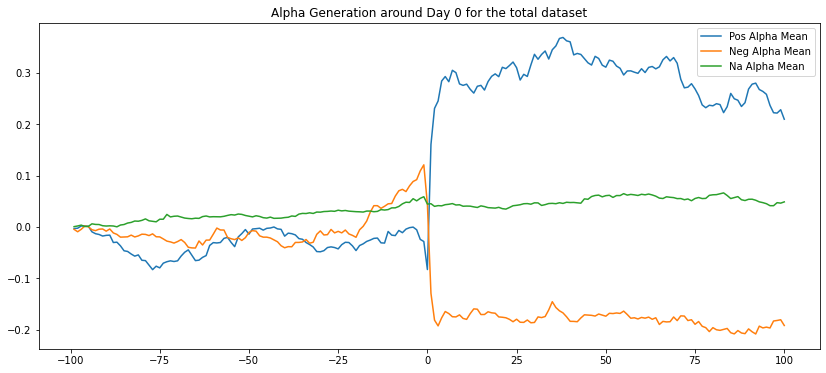

In [92]:
alpha_total.plot(kind='line',figsize=(14,6),title='Alpha Generation around Day 0 for the total dataset')

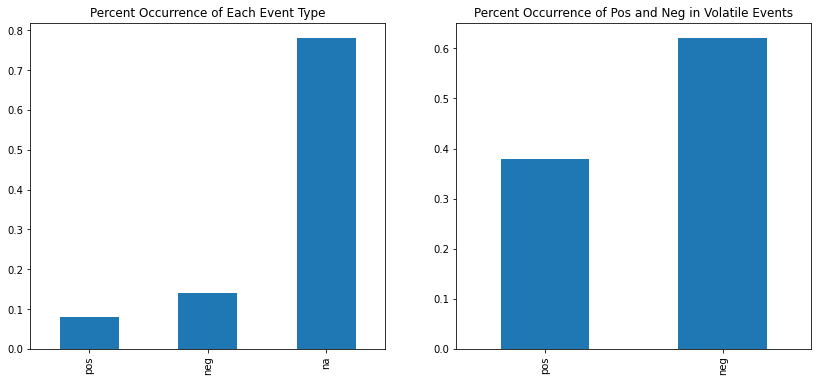

In [93]:
vol_events = pd.DataFrame({'Number':[len(pos_tickers),len(neg_tickers)]},index=['pos','neg'])
vol_events['Percent'] = (vol_events['Number'] / vol_events['Number'].sum()).round(decimals=2)

fig, axes = plt.subplots(ncols=2,figsize=(14,6))

events['Percent'].plot(ax=axes[0],kind='bar',title='Percent Occurrence of Each Event Type')
vol_events['Percent'].plot(ax=axes[1],kind='bar',title='Percent Occurrence of Pos and Neg in Volatile Events')

In [94]:
events

,Number,Percent
pos,49,0.08
neg,79,0.14
na,449,0.78


In [95]:
vol_events

,Number,Percent
pos,49,0.38
neg,79,0.62


> The two most important findings from the total dataset is that the pos and neg event alpha generation post Day 0 is asymmetric and that more negative events occur than positive. While a pos event results in an approximate mean abnormal (alpha) return of between 0.30 and 0.40 percent, a negative event results in around -0.20 percent return.

> The 'vol_events' dataframe consists only of events that were either pos or neg in outcome. This represents events where the outcome was impactful enough on price action to generate volatility in either direction and thus the name 'vol'. An understanding of the division between pos and neg events outcomes in the vol dataset is important; a good biotech analyst would only target catalyst events that have a chance of significant volatility. There are some events that are more volatile than others, FDA regulatory events for example are generally less volatile than clinical development catalysts like Phase readouts. It is logical that these could be weeded out with some degree of certainty based on qualitative analysis of individual catalysts, drugs, and the sponsor company. The greater occurrence of negative events is logical as more drugs fail than succeed. It is important to remember that this dataset contains FDA regulatory events (Approvals and CRLs) which can be less volatile. This is because a FDA approval is generally priced in after a successful Phase 3 clinical study. Price action around CRLs is more unpredictable, this is explored below.

> Non-FDA events are generally defined as those that are not Approvals or CRLs, corresponding to the Class data values of 'Approved' or 'CRL'. The Non-FDA event list is generated by those events that are not classified as FDA related because there are many different ways to structure Phases of drug development. Most companies generally follow the Phase 1-3 structure but sometimes Phase 1/2, Phase 2/3, Phase 2a/b trials can occur. It is easier to sort for these events by selecting those that are not FDA related and thus a phase of drug development. These events represent the majority of the dataset, it is important to isolate them to analyze returns as the FDA regulatory events could be affecting the mean.

In [96]:
def not_fda(aclass): #these are functions that pull events either for not_fda or fda events, pulls both days and tickers
    tick = final_df.loc[(final_df['Status'] != 'Approved') & (final_df['Status'] != 'CRL') & (final_df['Class'] == aclass),'Ticker'] 
    days = final_df.loc[(final_df['Status'] != 'Approved') & (final_df['Status'] != 'CRL') & (final_df['Class'] == aclass),'Day']
    return days.to_list(),tick.to_list()

def fda(aclass):
    fda_class = ['Approved','CRL']
    tick = final_df.loc[(final_df['Status'].isin(fda_class)) & (final_df['Class'] == aclass),'Ticker']
    days = final_df.loc[(final_df['Status'].isin(fda_class)) & (final_df['Class'] == aclass),'Day']
    return days.to_list(),tick.to_list()

In [97]:
# not fda events
not_fda_pos_days,not_fda_pos_tickers = not_fda('pos')
not_fda_neg_days,not_fda_neg_tickers = not_fda('neg')
not_fda_na_days,not_fda_na_tickers = not_fda('na')

# fda events
fda_pos_days,fda_pos_tickers = fda('pos')
fda_neg_days,fda_neg_tickers = fda('neg')
fda_na_days,fda_na_tickers = fda('na')

In [98]:
# not fda events
not_fda_pos = alpha_2(not_fda_pos_days,not_fda_pos_tickers).mean(axis=1)
not_fda_neg = alpha_2(not_fda_neg_days,not_fda_neg_tickers).mean(axis=1)
not_fda_na = alpha_2(not_fda_na_days,not_fda_na_tickers).mean(axis=1)

# fda events
fda_pos = alpha_2(fda_pos_days,fda_pos_tickers).mean(axis=1)
fda_neg = alpha_2(fda_neg_days,fda_neg_tickers).mean(axis=1)
fda_na = alpha_2(fda_na_days,fda_na_tickers).mean(axis=1)

not_fda = pd.DataFrame({'Not FDA Pos Mean':not_fda_pos,'Not FDA Neg Mean':not_fda_neg,'Not FDA Na Mean':not_fda_na})
fda = pd.DataFrame({'FDA Pos Mean':fda_pos,'FDA Neg Mean':fda_neg,'FDA Na Mean':fda_na})

In [99]:
not_fda_events = pd.DataFrame({'Number':[len(not_fda_pos_days),len(not_fda_neg_days),len(not_fda_na_days)]},index=['pos','neg','na']) #creates dataframe for non FDA events
not_fda_events['Percent'] = (not_fda_events['Number'] / not_fda_events['Number'].sum()).round(decimals=2) 

fda_events = pd.DataFrame({'Number':[len(fda_pos_days),len(fda_neg_days),len(fda_na_days)]},index=['pos','neg','na']) #creates dataframe for FDA events
fda_events['Percent'] = (fda_events['Number'] / fda_events['Number'].sum()).round(decimals=2)

In [100]:
not_fda_events

,Number,Percent
pos,46,0.10
neg,70,0.15
na,341,0.75


In [101]:
fda_events

,Number,Percent
pos,3,0.02
neg,9,0.08
na,108,0.90


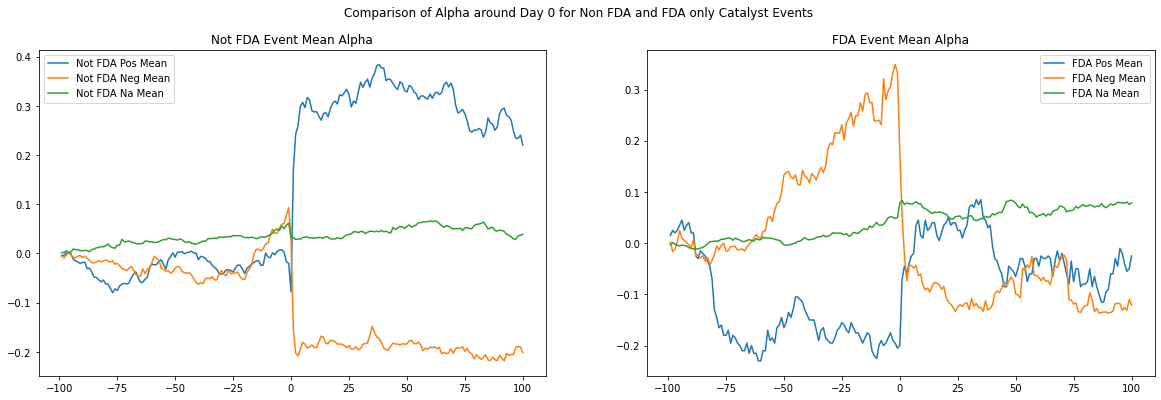

In [102]:
fig, axes = plt.subplots(ncols=2,figsize=(20,6))
fig.suptitle('Comparison of Alpha around Day 0 for Non FDA and FDA only Catalyst Events')
not_fda.plot(ax=axes[0],kind='line',title='Not FDA Event Mean Alpha')
fda.plot(ax=axes[1],kind='line',title='FDA Event Mean Alpha')

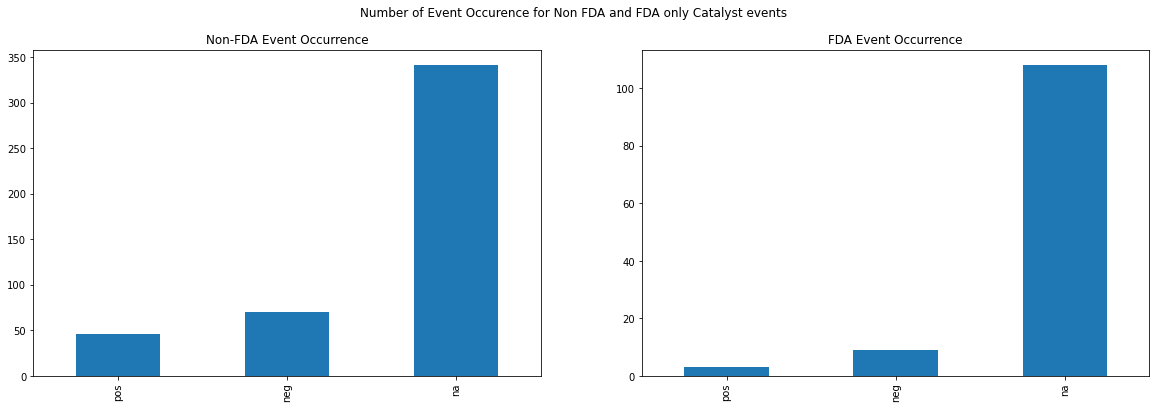

In [103]:
fig,axes= plt.subplots(ncols=2,figsize=(20,6))
fig.suptitle('Number of Event Occurence for Non FDA and FDA only Catalyst events')
not_fda_events['Number'].plot(ax=axes[0],kind='bar',title='Non-FDA Event Occurrence')
fda_events['Number'].plot(ax=axes[1],kind='bar',title='FDA Event Occurrence')

> The mean alpha generation from FDA related events is not useful but makes for an interesting point of comparison in the volatility of the non FDA events. The odd spike post Day 0 for the FDA dataset is not signficant as the dataset and respective mean is sensitive due to only 3 events in the dataset. It was caused by an unrelated spike in LUMO, this is shown on another chart below that displays individual alpha generation of the tickers in the FDA dataset. The chart serves the purpose of highlighting that there are much more 'na' events in the FDA dataset and that the sub-group as a whole generally trades flat through those events. The Non-FDA alpha generation chart is similar to the previous total dataset chart. This is because Non-FDA events make up the majority of the events in the dataset and thus influence the mean. Once again, there are more negative events than positive events as the biotech industry is generally associated with more failure than success.

> Many of the trends observed in the first dataset are also true of this one. The return profile for positive and negative events is generally asymmetric and there is a greater occurrence of negative than positive events. 

In [104]:
fda_alpha_pos = alpha_2(fda_pos_days,fda_pos_tickers) 

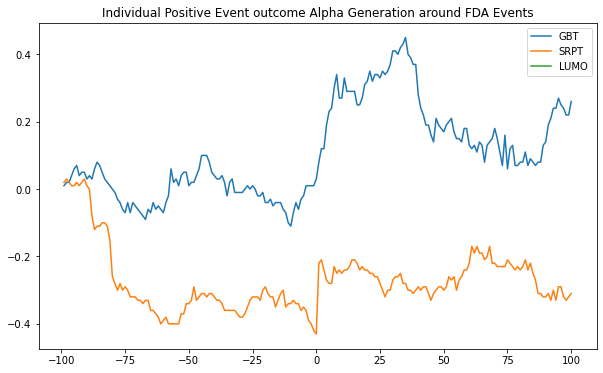

In [105]:
fda_alpha_pos.plot(kind='line',title='Individual Positive Event outcome Alpha Generation around FDA Events',figsize=(10,6))

> The individual alpha generation associated with LUMO shows that the spike around day 50-60 is not associated with systemic price action trends around FDA positive event outcomes. The dataset contains only 3 tickers and thus the mean was significantly affected. SRPT and GBT both exhibit relatively flat behaviour that is more characteristic of FDA events.

#### Biotech Fund Tickers

> The general hypothesis is that the outcome of catalyst events can be predicted using the tickers present in the form 13s of leading biotech funds. This hypothesis will be tested by representing the overlap between different groupings of tickers from the funds and catalysts in the dataset. The goal is to identify if there is a statistical edge to trading the stocks present in the book or books of various funds. The methodology is generally to analyze the tickers from the funds and sort them into lists based on repetitive ticker occurrence, then screen that list against pos, neg, and na catalyst outcomes to see if they outperform the baseline in terms of occurrence.

> The list of tickers for each of the 8 funds is added together to form a total list that is sorted to identify those tickers that occurred more than once, more than twice, and more than three times. Note that the functions return a unique list of tickers eliminating repetitive tickers when screening for repetitive occurrence. The total list is compared against the tickers in the total catalyst dataset for the period of analysis. This is done to sort for only those tickers that were associated with any catalyst event; it isolates the tickers that have upcoming catalysts. It is important to note that this function retains the duplicates that were originally present in the funds ticker list and only removes those tickers that were not associated with catalysts in the dataset. This step could be replicated qualitatively when attempting to trade the names in the list by checking the tickers against upcoming catalysts. This is bascially the list of tickers that are associated with catalyst events in the period of analysis.  

In [106]:
total_list = ra_cap+perc_adv+baker_bros+deerfield+broadfin+ecor1+healthcor+rtw

In [107]:
len(total_list)

368

In [108]:
all_tickers_catalysts = final_df['Ticker'].to_list()

In [109]:
len(all_tickers_catalysts)

577

In [110]:
screened_tickers = [a for a in total_list if a in all_tickers_catalysts]

In [111]:
len(screened_tickers)

163

There are a total of 369 tickers in the total fund list; 162 of these are also present in the catalyst ticker set. (not unique list) These tickers will act as the base for comparison between the fund tickers and pos/neg event occurrence in the main dataset. The code below creates different groups of the fund tickers based on occurrence; these groups were created to see if there was an increase in pos event occurrence as a percentage of the screened_ticker list with increased occurrence of the name. The sublists of the fund tickers contain 100, 42, and 11 names corresponding to the groupings of unique tickers, tickers that occur more than twice, and those that occur more than three times respectively. 

In [112]:
unique = count_greater_x(screened_tickers,1)
len(unique)

101

In [113]:
more_2 = count_greater_x(screened_tickers,2)
len(more_2)

42

In [114]:
more_3 = count_greater_x(screened_tickers,3)
len(more_3)

11

In [115]:
def find_same(alist,blist):
    res = [a for a in alist if a in blist]
    return res

> The specific set of tickers present in fund filings is then compared to lists of tickers that were associated with pos events in the catalyst dataset. Thus, the percent of the tickers in the fund list associated with a pos, neg, or na event can be compared with baseline outcomes. It is important to note that tickers in the total dataset can be associated with multiple event outcomes. This leads to percentages that do not neccessarily total to 100%.

> The most important outcome for the analysis of tickers associated with event outcomes is how pos and neg events are divided in a dataset excluding na events. While the alpha generation associated with na events is marginal, not resulting in a loss or gain, the optimal way to apply a strategy targeting catalyst events is to preemptively screen to identify those events that will be associated with a high degree of volatility in either direction. This is why the percent of pos and neg events in a selected volatile dataset is important. 

In [116]:
unique_pos = find_same(unique,pos_tickers)
unique_neg = find_same(unique,neg_tickers)
unique_na = find_same(unique,na_tickers)

more_2_pos = find_same(more_2,pos_tickers)
more_2_neg = find_same(more_2,neg_tickers)
more_2_na = find_same(more_2,na_tickers)

more_3_pos = find_same(more_3,pos_tickers)
more_3_neg = find_same(more_3,neg_tickers)
more_3_na = find_same(more_3,na_tickers)

In [117]:
funds_events = pd.DataFrame({'unique': [len(unique_pos),len(unique_neg),len(unique_na)],
                            'more_2': [len(more_2_pos),len(more_2_neg),len(more_2_na)],
                            'more_3': [len(more_3_pos),len(more_3_neg),len(more_3_na)]},
                           index = ['pos','neg','na'])

funds_events['unique_%'] = (funds_events['unique'] / len(unique)).round(decimals=2)
funds_events['more_2_%'] = (funds_events['more_2'] / len(more_2)).round(decimals=2)
funds_events['more_3_%'] = (funds_events['more_3'] / len(more_3)).round(decimals=2)

In [118]:
vol_funds_events = funds_events.loc[['pos','neg'],['unique','more_2','more_3']]

vol_funds_events['unique_%'] = (vol_funds_events['unique'] / vol_funds_events['unique'].sum()).round(decimals=2)
vol_funds_events['more_2_%'] = (vol_funds_events['more_2'] / vol_funds_events['more_2'].sum()).round(decimals=2)
vol_funds_events['more_3_%'] = (vol_funds_events['more_3'] / vol_funds_events['more_3'].sum()).round(decimals=2)

> The occurrence of tickers associated with pos, neg, and na events in the funds ticker list is shown below. The division of pos and neg events in a dataset excluding na events is also included. This data is significant because it illustrates that the percentage of pos events in a list of tickers pulled from biotech hedge fund form 13s is higher than the baseline. This is charted below.

In [119]:
funds_events

,unique,more_2,more_3,unique_%,more_2_%,more_3_%
pos,26,14,6,0.26,0.33,0.55
neg,21,7,2,0.21,0.17,0.18
na,77,34,8,0.76,0.81,0.73


In [120]:
vol_funds_events

,unique,more_2,more_3,unique_%,more_2_%,more_3_%
pos,26,14,6,0.55,0.67,0.75
neg,21,7,2,0.45,0.33,0.25


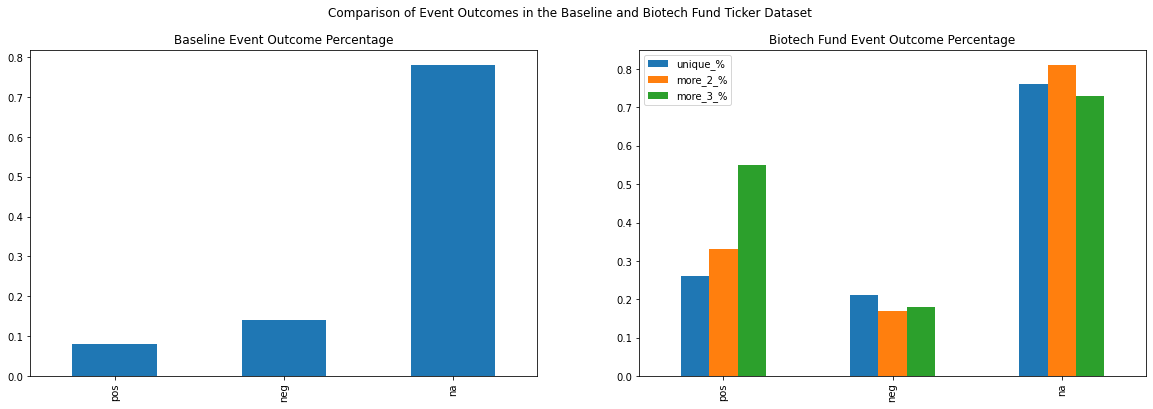

In [121]:
fig, axes = plt.subplots(ncols=2,figsize=(20,6))
fig.suptitle('Comparison of Event Outcomes in the Baseline and Biotech Fund Ticker Dataset')
funds_events[['unique_%','more_2_%','more_3_%']].plot(ax=axes[1],kind='bar',title='Biotech Fund Event Outcome Percentage')
events['Percent'].plot(ax=axes[0],kind='bar',title='Baseline Event Outcome Percentage')

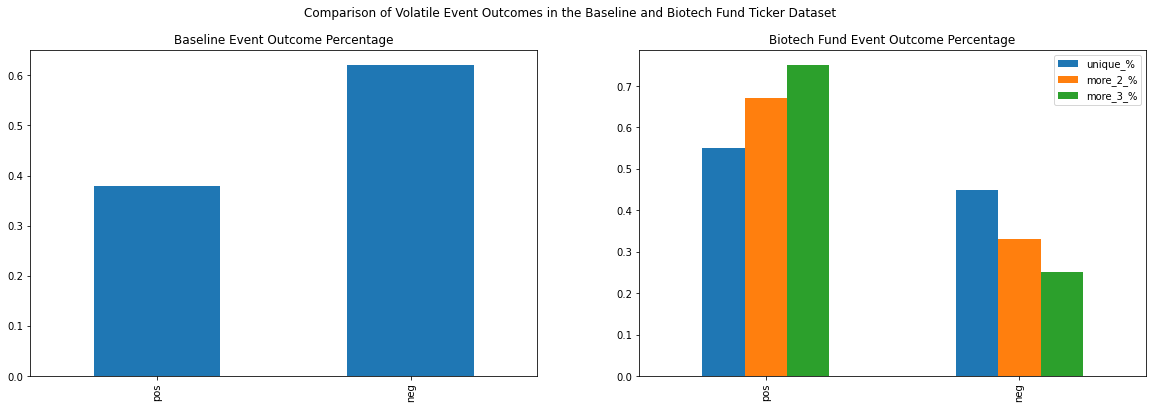

In [122]:
fig, axes = plt.subplots(ncols=2,figsize=(20,6))
fig.suptitle('Comparison of Volatile Event Outcomes in the Baseline and Biotech Fund Ticker Dataset')
vol_funds_events[['unique_%','more_2_%','more_3_%']].plot(ax=axes[1],kind='bar',title='Biotech Fund Event Outcome Percentage')
vol_events['Percent'].plot(ax=axes[0],kind='bar',title='Baseline Event Outcome Percentage')

> The above figures show the probability of event outcome by type in both the baseline dataset and fund ticker dataset. There are more positive event outcomes present in the fund dataset than in the baseline. This is supporting evidence for the original hypothesis that compiling form 13s of top biotech hedge funds can help to inform investment decisions regarding event outcomes in biotech catalyst evants. As previously mentioned, a likely important step in deploying this strategy would be using qualitative analysis to screen for events that would yield volatility in either direction. It is the subset of total events that are likely to exhibit volatile behaviour where this strategy would be most useful.

> While there is a direct relationship between ticker repitition in the fund dataset and pos event occurrence, as shown in the figure above. The number of tickers in the set become increasing smaller with each subsequent increase in required repitition for inclusion to the dataset. A criteria that a ticker occurs more than three times generates such a smaller number of tickers that it becomes difficult to quantify the mean of that alpha generation. This is a problem across the board, as shown below, one explanation might be that tickers that occur more than a given number of times become "priced in" and thus do not yield sufficient alpha to make the position worthwhile. While this may be true in some cases where success or failure is well understood and priced in, there are likely other scenarios where the results are inherently unknown and thus could still result in price action. Examples of this are more likely to be in clinical development catalysts than FDA associated events due to the increased volatility of clinical catalysts. The true mean as a result of these events is likely closer to the baseline mean for positive outcome events.   

In [123]:
pos_funds_tick = final_df.loc[(final_df['Class'] == 'pos') & (final_df['Ticker'].isin(unique_pos)),'Ticker'].to_list()
pos_funds_days = final_df.loc[(final_df['Class'] == 'pos') & (final_df['Ticker'].isin(unique_pos)),'Day'].to_list()

In [124]:
pos_funds_tick2 = final_df.loc[(final_df['Class'] == 'pos') & (final_df['Ticker'].isin(more_2_pos)),'Ticker'].to_list()
pos_funds_days2 = final_df.loc[(final_df['Class'] == 'pos') & (final_df['Ticker'].isin(more_2_pos)),'Day'].to_list()

In [125]:
pos_funds_tick3 = final_df.loc[(final_df['Class'] == 'pos') & (final_df['Ticker'].isin(more_3_pos)),'Ticker'].to_list()
pos_funds_days3 = final_df.loc[(final_df['Class'] == 'pos') & (final_df['Ticker'].isin(more_3_pos)),'Day'].to_list()

In [126]:
unique_funds_pos = alpha_2(pos_funds_days,pos_funds_tick)

In [127]:
more2_funds_pos = alpha_2(pos_funds_days2,pos_funds_tick2)

In [128]:
more3_funds_pos = alpha_2(pos_funds_days3,pos_funds_tick3)

In [129]:
comp_test = pd.DataFrame({'unique':unique_funds_pos.mean(axis=1),'more_2':more2_funds_pos.mean(axis=1),
                          'more_3':more3_funds_pos.mean(axis=1),'total dataset': pos_alpha})

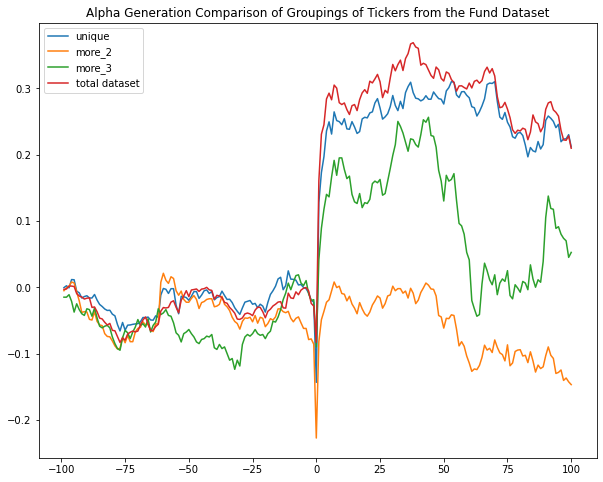

In [130]:
comp_test.plot(kind='line',figsize=(10,8),title='Alpha Generation Comparison of Groupings of Tickers from the Fund Dataset')

> An easy explanation of the increased underperformance compared to the baseline as the repitition of tickers increases is that they become 'priced in'. The fact that the dataset composed of tickers that occur more than 3 times (more_3) outperforms the list of tickers that occur twice (more_2) seems to conflict this idea. The volatility in price data and seeming lack of pattern associated with the above returns is likely due to the highly idiosyncratic tendencies of biotech stocks. While trends can be identified, they cannot account for all the variables present in the underlying drug, trial, and company. Thus, larger than normal datasets focused around a single variable or event are the most useful for analyzing thse stocks. The groups of tickers generated from the biotech hedge fund filings are significant and the percent chance of pos and neg event occurrence is an important finding, however the alpha generated by these same lists of stocks is not truly representative of a sufficient dataset due to their small size. 

> Further analysis detailing the alpha generation of pos, neg, and na event outcomes associated with tickers that occurred more than once in the biotech funds ticker set were completed as the 'unique' ticker set was by far the largest and thus the best representation of alpha generation from those tickers. See the chart below.

In [131]:
unique_neg_tick = final_df.loc[(final_df['Class'] == 'neg') & (final_df['Ticker'].isin(unique_neg)),'Ticker'].to_list()
unique_neg_days = final_df.loc[(final_df['Class'] == 'neg') & (final_df['Ticker'].isin(unique_neg)),'Day'].to_list()

unique_na_tick = final_df.loc[(final_df['Class'] == 'na') & (final_df['Ticker'].isin(unique_na)),'Ticker'].to_list()
unique_na_days = final_df.loc[(final_df['Class'] == 'na') & (final_df['Ticker'].isin(unique_na)),'Day'].to_list()

In [132]:
unique_neg_alpha = alpha_2(unique_neg_days, unique_neg_tick)
unique_na_alpha = alpha_2(unique_na_days, unique_na_tick)

In [133]:
unique_df = pd.DataFrame({'Pos Unique Fund Tickers Mean': unique_funds_pos.mean(axis=1),'Neg Unique Fund Tickers Mean': unique_neg_alpha.mean(axis=1),
                          'Na Unique Funds Tickers Mean': unique_na_alpha.mean(axis=1)})

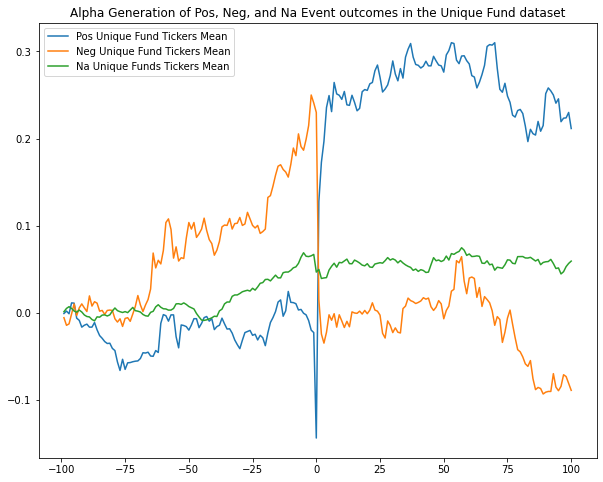

In [134]:
unique_df.plot(kind='line',figsize=(10,8),title='Alpha Generation of Pos, Neg, and Na Event outcomes in the Unique Fund dataset')

> The chart above of alpha generation in the fund dataset by event outcome is interesting as it shows that the negative events in this dataset have a significant run up before event. The events that ultimately had a negative event also retract less than baseline events after a negative event. This could indicate that the presence of these ultimately negative events associated with tickers in the funds dataset are considered by the market to be likely to succeed due to their association with these funds. Thus, there is significant price action indicative of a positive outcome before the event date. While one could try to capitalize on the mean alpha generation of ultimately negative events before the event date, this must be done carefully to avoid the eventually negative outcome and negative return. This could possibly be achieved by isolating events that trade close to the mean of these 'false positive' negative events. It should be considered however that catalysts are not always as timely as investors would like them to be, making this kind of trade difficult. Some catalysts have vague release dates anywhere from half a financial year to a specific month. 

> A note on the negative alpha spike (approximately -0.15) around event date 0 for the pos event outcome group. This appears to be an error but is really just the AGRX event volatility around the Advisory Committee meeting on 2019-10-30 or Day 753. Both are shown below. The stock declined approximately 50% before the event but it eventually recovered due to a successful meeting. This pattern is causing the apparent data blip on the pos unique alpha chart, it is not a systemic trend just a result of the inclusion of AGRX in the dataset. To illustrate this point, a chart of AGRX alpha generation around the event is shown below. This is the data that would be included in the mean charted above.  

In [135]:
final_df.loc[final_df['Ticker'] == 'AGRX','Date']

1829   2019-10-30
Name: Date, dtype: datetime64[ns]

In [136]:
final_df.loc[final_df['Ticker'] == 'AGRX','Day']

1829    753
Name: Day, dtype: int64

In [137]:
agrx_alpha = alpha_2([753],['AGRX'])

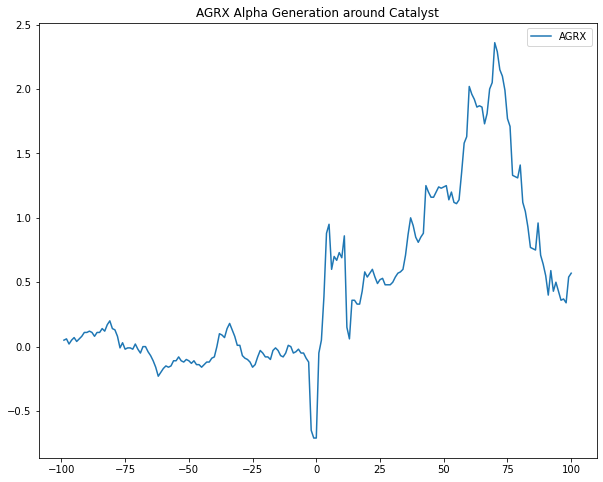

In [138]:
agrx_alpha.plot(kind='line',title='AGRX Alpha Generation around Catalyst',figsize=(10,8))

#### Possible Applications of Findings

> The possible applications of these findings are varied. The two most apparent are a betting approach that attempts to maximize returns by treating each catalyst event as a repeatable gamble and the other is approach where the generated list of tickers from the funds is treated as a source of idea genesis for potentially interesting catalysts. Either of these approaches involve two steps, the first is weeding out the non volatile events and associated tickers, the second is screening the tickers and isolating only those that are associated with catalysts in the next 180 trading day period. The latter of those steps would likely be performed first and both steps would probably contain some level of qualitative analysis. The betting approach is mathematically the most interesting and complex. The other approach yields a short list of tickers that have a better than normal chance of success, regular biotech analysis of the underlying drug and company is then performed to develop an opinion on a given event in this list.

> When discussing maximizing a repeatable gamble over several subsequent trials, the Kelly Criterion is often used. This is a mathematical equation that attempts to maximize the amount of return generated over time. While this is mathematically valid, many prefer 'half kelly' or 'quarter kelly' which is the Kelly Percentage divided by an adjustment to limit the volatility of the returns over time. The output of the kelly equation dictates the amount of the bankroll the hypothetical gambler should bet given the probability of a win, amount gained when you win, and amount lost when you lose. This equation is shown below; the function defined below solves for the Kelly Percentage based on inputs of win probability, amount won, and amount lost. 

![Kelly Criterion](kelly_crit.PNG)

In [139]:
def kelly(prob,win,loss): #simple function to return the kelly % based on the equation 
    k = prob - (1-prob)/(win/abs(loss))
    return round(k,2)

In [140]:
# example of kelly criterion generation where probability of win is 0.55, amount won is 3, amount lost is 2.
kelly(0.55,3,2)

0.25

> One consideration for the application of this idea to these specific findings is that the discrete kelly equation works with a binomial outcome, basically there needs to be two outcomes. In this analysis there were three possible outcomes; as previously discussed qualitative analysis can be used to identify a subset of the catalysts events that are likely to have a higher degree of volatility. An ideal vol subset would create a binomial outcome. The accuracy of this analysis actually becomes important if attempting to apply a strategy where one of the outcomes results in no change in capital. This situation is modeled below. Another important note is that Kelly betting assumes that the amount won or lost is concrete. This may not neccessarily be true for events in this dataset, in general there was an assymetric return profile when comparing the positive and negative event outcomes. The important distinction is how great of a difference this actually is. The models below use a conservative estimate. 

> The functions below use numpy and random array to create simulations in which the mean of the trials can be compared to other simulations where specific variables are tweaked. The second sim function has been edited to be multinomial and support the creation of a game that models a certain percentage of 'na' outcome in which the amount of capital goes unchanged. While this is a simplification of the actual outcomes observed in na events present in this dataset, it is an approximation for the sake of analysis.

> Assuming that the mean return of pos events and the mean return of neg events are the win and loss amount respectively. A 'win' associated with a positive outcome would have 0.30 percent return while a 'loss' associated with a negative event would have -0.20 percent return. Note that the win to loss ratio represented by R on the equation figure is a ratio. Thus, the numbers don't matter as long as they represent an equal ratio to the other fractions. An example of this is demonstrated below. 

In [141]:
kelly(0.55,3,2) == kelly(0.55,300,200) == kelly(0.55,0.3,0.2) #demonstrates the ratio is equal

True

> Using the mean return of positive and negative events as discussed above, the probability of a win can be set equal to 0.55 as calculated in the volatile subset of unique tickers from the funds. Thus, the kelly criterion for a hypothetical biotech event is shown below. The adjustments of 0.5 and 0.25 kelly are also shown.

In [142]:
print('Kelly %: ',kelly(0.55,3,2))
print('0.5 Kelly %: ',kelly(0.55,3,2)/2)
print('0.25 Kelly %: ',kelly(0.55,3,2)/4)

Kelly %:  0.25
0.5 Kelly %:  0.125
0.25 Kelly %:  0.0625


In [143]:
# these are the parameters for both functions that create the simulation

I = 50 #The number of series to be simulated.
n = 100 #The number of trials per series.
np.random.seed(1) 

In [144]:
# this is the function that defines the simulation for a normal binomial random outcome -- this is an ideal dataset containing only 
# outcomes that produce volatile results

def run_sim1(f,p):
    c = np.zeros((n, I)) #creates np array of right size
    c[0] = 100 #starting value
    for i in range(I): #outer loop 
        for t in range(1,n): #inner loop
            o = np.random.binomial(1, p) #random numbers for trials
            if o > 0: 
                c[t, i] = (1+f) * c[t-1,i] #win
            else: 
                c[t, i] = (1-f) * c[t-1,i] #loss
                
    # this just formats into percent return
    adj = np.zeros((n, I))
    for a in range(n):
        adj[a,:] = c[a,:] / c[0,:] -1 #this is cumulative percent return which is just percent change since beginning
    return adj


In [145]:
# this is the function that defines the simulation for a multinomial random outcome -- this accounts for the occurrence of na events, 
# or outcomes that do not have a major impact 
# on total returns. Percent of na events is defined as 0.10 in the first example. 

def run_sim2(f,p,na):
    c = np.zeros((n, I)) 
    c[0] = 100 
    for i in range(I): 
        for t in range(1,n): 
            o = np.random.multinomial(1, [p,na,1-(p+0.10)]) #multinomial, generates three number that the equations below analyze
            if o[0] > 0: 
                c[t, i] = (1+f) * c[t-1,i] 
            elif o[1] >0:
                c[t,i] = c[t-1,i] #this is the na event outcome which just means nothing happens  
            else: 
                c[t, i] = (1-f) * c[t-1,i] 
                
    # this just formats into percent return
    adj = np.zeros((n, I))
    for a in range(n):
        adj[a,:] = c[a,:] / c[0,:] -1 #formats into cumulative return
    return adj


In [146]:
# round of simulation with modification to Kelly %
f1 = 0.25

k1 = run_sim1(f1,0.55)
k2 = run_sim1(f1/2,0.55)
k3 = run_sim1(f1/4,0.55)

In [147]:
# round of simulation with same kelly % but varying the percent of na events. The percent of na events is
# found by subtracting 1/2 of total na percent from both pos and neg outcomes. 
f1 = 0.25

ka1 = run_sim2(f1,0.50,0.10) #win = 0.50, lose = 0.40, na = 0.10
ka2 = run_sim2(f1/2,0.45,0.20) #win = 0.45, lose = 0.45, na = 0.20
ka3 = run_sim2(f1/4,0.40,0.30) #win = 0.40, lose = 0.45, na = 0.20

Text(0, 0.5, '% Return on Capital')

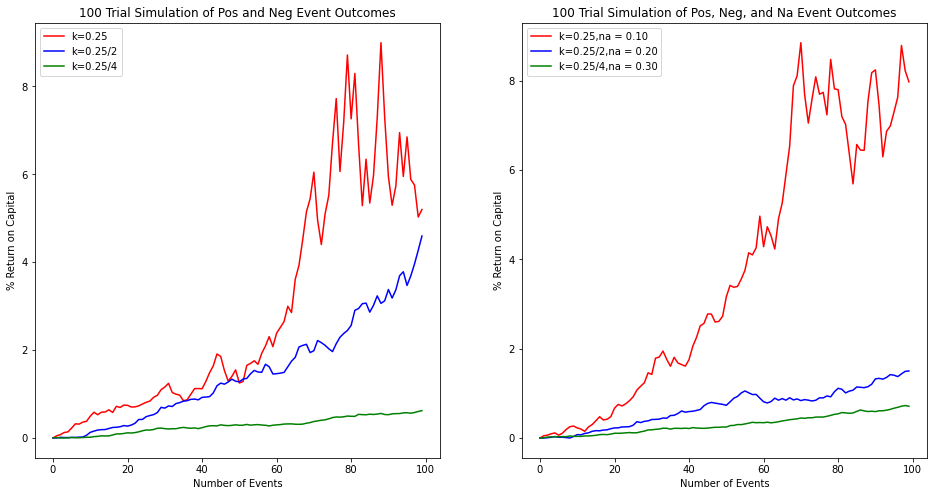

In [148]:
# this is sim1 where there is only two outcomes. 
plt.subplots(figsize=(16,8))
plt.subplot(1,2,1)
plt.plot(k1.mean(axis=1),'r',label='k=0.25')
plt.plot(k2.mean(axis=1),'b',label='k=0.25/2')
plt.plot(k3.mean(axis=1),'g',label='k=0.25/4')
plt.legend(loc='upper left')
plt.title('100 Trial Simulation of Pos and Neg Event Outcomes')
plt.xlabel('Number of Events')
plt.ylabel('% Return on Capital')
# this is sim2 where there are three outcomes
plt.subplot(1,2,2)
plt.plot(ka1.mean(axis=1),'r',label='k=0.25,na = 0.10')
plt.plot(ka2.mean(axis=1),'b',label='k=0.25/2,na = 0.20')
plt.plot(ka3.mean(axis=1),'g',label='k=0.25/4,na = 0.30')
plt.legend(loc='upper left')
plt.title('100 Trial Simulation of Pos, Neg, and Na Event Outcomes')
plt.xlabel('Number of Events')
plt.ylabel('% Return on Capital')

> The charts above show that while na event outcomes are not ideal, they do not ultimately affect the return on capital. This is an important conclusion and is driven by the fact that no change in capital is better than a loss of capital. While the return on the right, with na events included, seem attractive it is unrealistic to purposefully incorporate events that are unlikely to produce significant capital. It ties up capital that could be used for other things that would yield a return outside of 0%. 

#### Alpha Generation of Specific Hedge Funds

> The specific alpha generation of each hedge fund included in the analysis is shown below. This is an approximate proxy for how 'good' each fund is relative to the others. Since form 13 filings only contain stock that funds are long, the best measure for how good a fund is at long exposure is the alpha associated with pos events. Only the pos events of each fund is compared, there are 8 of them and it becomes difficult to interpret the chart with that many variables. This analysis does not account for how the funds handle negative event outcomes, it only measures how good they are at picking positive events that yield a high alpha. This analysis also does not account for the total number of pos events, only the alpha associated with those events.

In [149]:
def find_fund_stuff(alist): #this finds the days and tickers for the funds pos events
    days = final_df.loc[(final_df['Class'] == 'pos')&(final_df['Ticker'].isin(alist)),'Day']
    tick = final_df.loc[(final_df['Class'] == 'pos')& (final_df['Ticker'].isin(alist)),'Ticker']
    
    return days.to_list(),tick.to_list()

In [150]:
# this pulls the tickers and days, for each of the respective funds
ra_days,ra_tick = find_fund_stuff(ra_cap)
perc_days,perc_tick = find_fund_stuff(perc_adv)
broadfin_days,broadfin_tick = find_fund_stuff(broadfin)
baker_days,baker_tick = find_fund_stuff(baker_bros)
deerfield_days,deerfield_tick = find_fund_stuff(deerfield)
ecor1_days,ecor1_tick = find_fund_stuff(ecor1)
healthcor_days,healthcor_tick = find_fund_stuff(healthcor)
rtw_days,rtw_tick = find_fund_stuff(rtw)

In [151]:
# this generates the alpha for the respective days and tickers for each funds 
ra_alpha = alpha_2(ra_days,ra_tick)
perc_alpha = alpha_2(perc_days, perc_tick)
broadfin_alpha = alpha_2(broadfin_days,broadfin_tick)
baker_alpha = alpha_2(baker_days,baker_tick)
deerfield_alpha = alpha_2(deerfield_days,deerfield_tick)
ecor1_alpha = alpha_2(ecor1_days,ecor1_tick)
healthcor_alpha = alpha_2(healthcor_days,healthcor_tick)
rtw_alpha = alpha_2(rtw_days,rtw_tick)

In [152]:
funds_mean = pd.DataFrame({'RA':ra_alpha.mean(axis=1),
                           'Perc Adv':perc_alpha.mean(axis=1),'Broadfin':broadfin_alpha.mean(axis=1),'Baker Bros':baker_alpha.mean(axis=1),
                                                      'Deerfield':deerfield_alpha.mean(axis=1),'Ecor1':ecor1_alpha.mean(axis=1),'Healthcor':healthcor_alpha.mean(axis=1),
                          'RTW':rtw_alpha.mean(axis=1)})

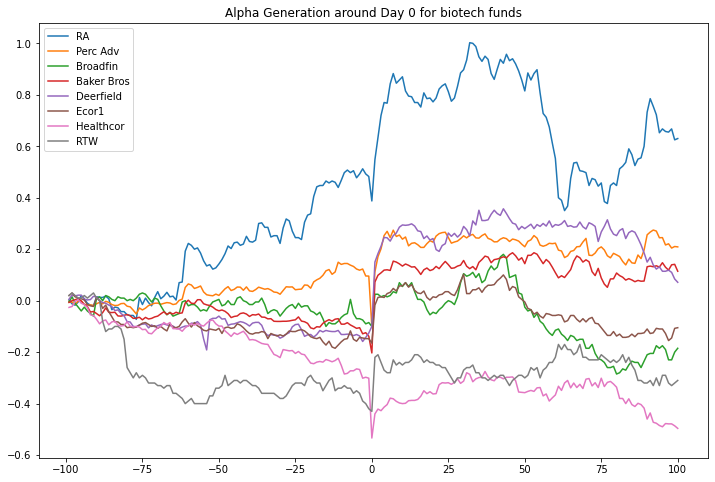

In [153]:
funds_mean.plot(kind='line',figsize=(12,8),title='Alpha Generation around Day 0 for biotech funds')

In [154]:
funds_occurrence = pd.DataFrame({'Pos Events':[len(ra_tick),len(perc_tick),len(broadfin_tick),len(baker_tick),len(deerfield_tick),len(ecor1_tick),len(healthcor_tick),len(rtw_tick)]},index = ['RA','Perc','Broadfin','Baker','Deerfield','Ecor1','Healthcor','RTW']) #creates dataframe with number of events for each fund

In [155]:
funds_occurrence

,Pos Events
RA,4
Perc,20
Broadfin,2
Baker,16
Deerfield,7
Ecor1,4
Healthcor,8
RTW,1


> The number of events is important as it provides context to how many pos events were associated with each list of tickers. RA Capital may have the highest mean alpha generation but they also have a low number of pos events. This Perceptive Advisors (perc) on the other hand has the highest number of pos events and the second highest mean alpha generation. These are important considerations when discussing the outcomes from tickers in these portfolios.

#### Beta of Unique Tickers in Total Dataset

> As part of the methodology for calculating the alpha of the various tickers, the beta to the specified index over the entire price data is calculated. Normally in biotech projects XBI is used as it is considered to be a better index. Below the beta of the unique tickers is compared to both XBI and SPY. The results are plotted; the beta to SPY was generally higher with a mean beta of 1.1 while the mean beta to XBI was 0.82. The distribution of beta to SPY was much wider than beta to XBI. 

In [156]:
def find_beta(df,index): #this generates the beta for each symbol
    daily = df.pct_change().drop(['Day'],axis=1) # uses price data that is already generated but needs to drop 'Day' column
    beta = pd.Series({symbol: (daily[index].cov(daily[symbol]) / daily[index].var()).round(decimals=2) # calc beta for each symbol
               for symbol in daily 
               if symbol != index})
    return beta # outputs pd series with each symbol as the index of the series, this can be used to find the mean. 

In [157]:
beta_xbi = find_beta(price_data,'XBI')

In [158]:
beta_xbi.mean().round(decimals=2) # this is the mean beta to XBI for the symbols in the dataset

0.82

In [159]:
w_spy = unique_tickers + ['SPY'] # adds SPY as a ticker to the ticker list, SPY is the index used to calc beta in this example

In [160]:
price_spy = stock_data(w_spy,date1,date2) # generates a price data array that contains SPY as the index instead of XBI. Uses the same dates as the primary price array. 

In [161]:
# the find_beta function has a line that drops the day count column normally included in the price data, a new find_beta function is defined with the only difference 
# being that the .drop(['Day']) is removed. 

def find_beta_spy(df,index): # inputs are the dataframe containing price data, the the specified index, beta is calc over entire price data period
    daily = df.pct_change() # pct change
    beta = pd.Series({symbol: (daily[index].cov(daily[symbol]) / daily[index].var()).round(decimals=2) # this is the covar / var
               for symbol in daily 
               if symbol != index}) # applied to all symbols that arent the index 
    return beta # this is a series with the beta for each ticker

In [162]:
beta_spy = find_beta_spy(price_spy, 'SPY')

In [163]:
beta_spy.mean().round(decimals=2) # this is the mean beta to SPY for the tickers in the dataset

1.1

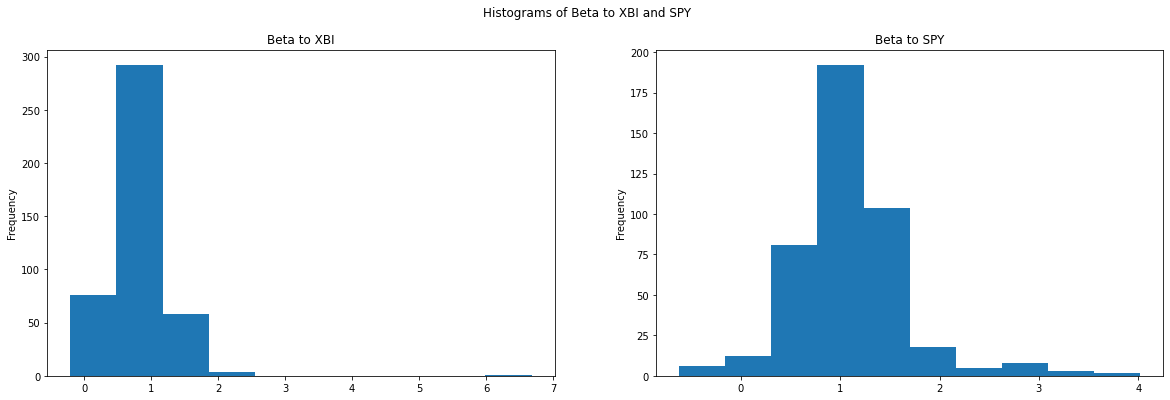

In [164]:
fig, axes = plt.subplots(ncols=2,figsize=(20,6))
fig.suptitle('Histograms of Beta to XBI and SPY')
beta_xbi.plot(kind='hist',title='Beta to XBI',ax=axes[0])
beta_spy.plot(kind='hist',title='Beta to SPY',ax=axes[1])

#### Considerations for Qualitative Analysis

> Qualitative analysis in an important part of making the most use of this strategy. While there is little loss or gain in terms of return associated with events with the na outcome, identifying these events is important as they tie up capital that could be better utilized other ways. By identifying these na events and only engaging with events that are likely to have a volatile outcome, more focus and capital can be dedicated to positions that can yield sufficient alpha. Qualitative analysis is also important in determining which tickers present in the fund ticker dataset are associated with upcoming catalysts. This could likely be automated with a solid datasource on forward catalysts and asssociated tickers. 

> In terms of identification of potentially 'na' events. There is some evidence that eliminating FDA events can be helpful as the percent occurrence of na event outcomes in the FDA event dataset is higher than the non-FDA event dataset. Ultimately, every catalyst event is different, this analysis makes generalizations based on large sample sizes that ignore many of these individual characteristics. The determination of 'na' events is the only part of this analysis that is not readibly able to automated. The screening of fund tickers to determine those that are associated with catalysts in a given period could be automated. The elimination of 'na' events is not so easy but is definitely achievable. Things to generally look for are events that add little new knowledge to what is already known about the drug. These events are mostly formalities that do not effect the valuation in a significant enough way to constitute volatile price action. Determining whether the event is important enough to the current valuation of the company is generally the first step of qualitative analysis with the subsequent step being predicting the outcome of the event. A small number of na events would not be the worst thing as they result in no price action in either direction. 

In [168]:
#exporting some archives for further analysis

#creating a dataframe with the info from the funds
a = {'RA':ra_cap,'Perc':perc_adv,'Baker Bros':baker_bros,'Deerfield':deerfield,'Broadfin':broadfin,'Ecor1':ecor1,'Healthcor':healthcor,'RTW':rtw,'unique':unique,'more_2':more_2,'more_3':more_3}
fundExport = pd.DataFrame.from_dict(a,orient='index').transpose()

fundExport.to_csv('fundTickersExport.csv',index=False) #archives the tickers to a csv

final_df.to_csv('baselineDatasetFinal.csv',index=False) #archives the baseline dataset from the period of analysis to a csv